In [128]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import pickle
import nltk
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections.abc import Iterable

In [129]:
def load_dataset(file_path:str):
    '''
    Imports the ColBERT dataset given a valid .CSV file.
    '''
    data = pd.read_csv(file_path)
    stop_words = set(stopwords.words('english'))
    features = pd.read_csv(file_path, usecols=['text']).values[0:5000]
    labels = pd.read_csv(file_path, usecols=['humor']).values[0:5000]
    
    return features, labels

In [145]:
features, labels = load_dataset("data/dataset.csv")
example_datapoint = random.randint(0,5000)
print(features[example_datapoint])
print("humor: " + str(labels[example_datapoint]))

['People with high diabetes risk could lower heart risks by walking more each day: study']
humor: [False]


In [154]:
class HumorDetector(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(HumorDetector, self).__init__()
        
        #Creating layers of perceptron
#         self.lin1 = nn.Linear(vocab_size, 500)
#         self.embedding = nn.Embedding(vocab_size, 3000)
#         self.embedding = nn.Embedding(3000, 1000)
#         self.embedding = nn.Embedding(1000, 500)
#         self.embedding = nn.Embedding(500, embed_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lin = nn.Linear(embed_dim, 1)
        self.relu = nn.ReLU() 
    
    def forward(self, x):
#         x = self.lin1(x)
#         x = self.lin(self.embedding(x))
#         x = self.relu(x)
#         x = nn.Sigmoid()(torch.sum(x/(x.size(dim=0))))
#         return x
        return nn.Sigmoid()(torch.sum(self.lin(self.relu(self.embedding(x))))/(x.size(dim=0)))

In [155]:
#This code creaters the text_pipeline, which will transform a string of raw text into tensors that we can train on.
tokenizer = get_tokenizer('basic_english')
train_iter = AG_NEWS(split='train')
stop_words = set(stopwords.words('english'))
punctuation_words = ['(', ')', '.', ',', '-']
# print(stop_words)
print(len(stop_words))
def yield_tokens(data_iter):
    for _, text in data_iter:
        
#         yield tokenizer(text)
#         print(len(text))
#         print(text)
        filtered_sentence = [w for w in tokenizer(text) if not w.lower() in (stop_words or punctuation_words)]
#         print(len(filtered_sentence))
#         print(filtered_sentence)
        yield filtered_sentence
#         yield tokenizer(text)

# print(vocab)
vocab = yield_tokens(train_iter)
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
print(len(vocab))
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))

179
95659


In [156]:
def forward_pass_wrapper(model, text_pipeline, input_array, i):
    '''
    model - the model with the forward pass function that is being performed
    text_pipeline - string-to-tensor function created earlier
    input_array - array that we are taking input from (in our case, features)
    i - the index in the array we are performing the forward pass on
    '''
    return model(torch.tensor(text_pipeline((input_array[i])[0])))
def bool_to_int(boolean):
    if (boolean):
        return 1.0
    else:
        return 0.0

In [157]:
#Sample output for untrained model - should be a number between 0 and 1.

test_model = HumorDetector(len(vocab), 64)
print(forward_pass_wrapper(test_model, text_pipeline, features, example_datapoint))

tensor(0.4651, grad_fn=<SigmoidBackward0>)


In [135]:
def training(model, loss_function, optimizer, features, labels, n_epochs, update_interval):
    
    losses = []
    avg_loss = []

    for n in range(n_epochs):
        for i in (tqdm(range(features.size))):

            optimizer.zero_grad()
            my_output = forward_pass_wrapper(model, text_pipeline, features, i)
            label = torch.tensor(bool_to_int((labels[i])))
            loss = loss_function(my_output, label)
            loss.backward()
            optimizer.step()
            
            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) # This will append your losses for plotting -- please use "loss" as the name for your loss
                avg_loss.append(sum(losses)/len(losses))
        
    return model, losses, avg_loss

95659


100%|██████████| 5000/5000 [06:49<00:00, 12.21it/s]


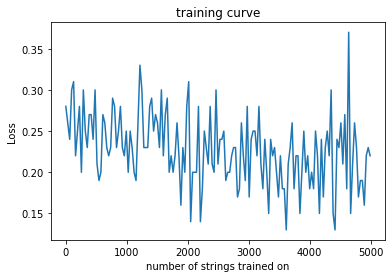

In [136]:
#Hyperparameters
lr = 1e-4
n_epochs = 1
update_interval = 32
print(len(vocab))
model = HumorDetector(len(vocab), 64) 

loss_function = nn.MSELoss()                        
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

trained_model, losses, avg_loss = training(model, loss_function, optimizer, features, labels, n_epochs, update_interval)

plt.plot(np.arange(len(losses)) * update_interval, losses)
plt.title("training curve")
plt.xlabel("number of strings trained on")
plt.ylabel("Loss")
plt.show()

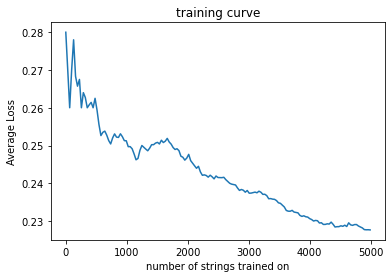

In [137]:
plt.plot(np.arange(len(avg_loss)) * update_interval, avg_loss)
plt.title("training curve")
plt.xlabel("number of strings trained on")
plt.ylabel("Average Loss")
plt.show()

In [148]:
#Briefly testing the trained model (higher number = more funny)
test_strings = ["How do you get a 100 cows into a barn? put up a bingo sign!",
                "People with high diabetes risk could lower heart risks by walking more each day: study"]
print("Funny value of a joke (funny):")
print(forward_pass_wrapper(trained_model, text_pipeline, test_strings, 0).item())
print("Funny value of a statement (not funny):")
print(forward_pass_wrapper(trained_model, text_pipeline, test_strings, 1).item())

Funny value of a joke (funny):
0.30055055022239685
Funny value of a statement (not funny):
0.43794938921928406
